In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import gensim
import nltk
from gensim.models.word2vec import Word2Vec
import tensorflow as tf
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')
import re
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/hp/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)
[nltk_data] Downloading package stopwords to /Users/hp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read the file
df3 = pd.read_csv('/users/hp/desktop/Ds-springboard/capstone_2/data/Reduced_Cleaned_Reviews_electronics_headphones.csv')



In [3]:
df3['rating_class'] = df3['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)
X = df3['clean_text']
y = df3['rating_class']

In [4]:
df3['clean_text'][:5]

0    vizio bluetooth stereo headphones please headp...
1    agree good headphone pair iphone easily sound ...
2    uncomfortable tinny sound buy read review try ...
3    uncomfortable headphones headphones look moder...
4    sound good bad fit two star knock must use nar...
Name: clean_text, dtype: object

## Tokenizer

In [5]:
from keras.preprocessing.text import Tokenizer

samples = X
tokenizer = Tokenizer(lower=True, split=' ') # creates tokenizer
tokenizer.fit_on_texts(samples)  # builds the word index
sequences = tokenizer.texts_to_sequences(samples) #turns strings into list of integers
# word_index is a dictionary mapping words to an integer index
word_index = tokenizer.word_index 
print(f'Found {len(word_index)} unique tokens. ')

Found 26548 unique tokens. 


In [6]:
max([max(sequence) for sequence in sequences])

26548

In [7]:
# Each number is the index of the word in the order of word in original text
sequences[0]

[2752, 99, 327, 3, 296, 2753, 333, 9518, 9519, 2, 6905, 14, 56, 4933, 269]

In [8]:
word_index

{'not': 1,
 'sound': 2,
 'headphones': 3,
 'great': 4,
 'good': 5,
 'use': 6,
 'quality': 7,
 'work': 8,
 'get': 9,
 'like': 10,
 'price': 11,
 'buy': 12,
 'ear': 13,
 'would': 14,
 'bass': 15,
 'pair': 16,
 'well': 17,
 'better': 18,
 'fit': 19,
 'one': 20,
 'no': 21,
 'make': 22,
 'really': 23,
 'comfortable': 24,
 'noise': 25,
 'look': 26,
 'music': 27,
 'go': 28,
 'love': 29,
 'much': 30,
 'ears': 31,
 'listen': 32,
 'nice': 33,
 'time': 34,
 'phone': 35,
 'come': 36,
 'headphone': 37,
 'little': 38,
 'product': 39,
 'try': 40,
 'also': 41,
 'cord': 42,
 'hear': 43,
 'best': 44,
 'set': 45,
 'even': 46,
 'earbuds': 47,
 'want': 48,
 'cable': 49,
 'head': 50,
 'say': 51,
 'need': 52,
 'think': 53,
 'volume': 54,
 'beat': 55,
 'recommend': 56,
 'bud': 57,
 'could': 58,
 'wear': 59,
 'audio': 60,
 'bose': 61,
 'find': 62,
 'purchase': 63,
 'long': 64,
 'give': 65,
 'still': 66,
 'feel': 67,
 'way': 68,
 'case': 69,
 'pretty': 70,
 'review': 71,
 'first': 72,
 'seem': 73,
 'around': 74

In [9]:
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in sequences[0]])

In [10]:
def sequence_to_text(sequence):
    words =  [reverse_word_index.get(letter) for letter in sequence]
    return words

my_text = list(map(sequence_to_text, sequences))

In [11]:
print(sequences[0])

[2752, 99, 327, 3, 296, 2753, 333, 9518, 9519, 2, 6905, 14, 56, 4933, 269]


## Word2Vec and Simple Neural Network

In [12]:
word2vec = gensim.models.Word2Vec(my_text,
                                  size=100,
                                  window=10,
                                  min_count=1)
word2vec.train(my_text, total_examples=25026, epochs=10)

(4958267, 5916150)

In [26]:
similar_words = {search_term: [item[0] for item in word2vec.wv.most_similar([search_term], topn=5)]
                  for search_term in ['feel', 'good', 'product', 'cheap', 'junk', 'bad', 'great','price','love']}
similar_words

{'feel': ['felt', 'grownand', 'beatssound', 'kind', 'kinda'],
 'good': ['decent', 'great', 'predominantly', 'reasonable', 'nice'],
 'product': ['item', 'products', 'company', 'timely', 'seller'],
 'cheap': ['flimsy', 'chinsey', 'cheaply', 'fragile', 'mealso'],
 'junk': ['crap', 'garbage', 'upset', 'fake', 'trash'],
 'bad': ['terrible', 'horrible', 'okay', 'konk', 'okey'],
 'great': ['fantastic', 'excellent', 'good', 'awesome', 'terrific'],
 'price': ['cost', 'tonejust', 'expensive', 'pricei', 'halfprice'],
 'love': ['awesome', 'pink', 'cute', 'birthday', 'momthese']}

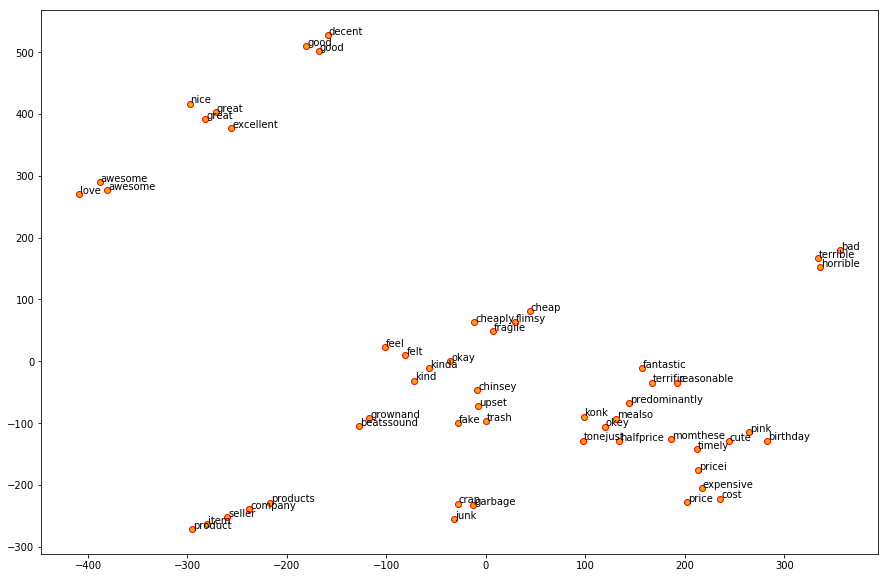

In [42]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = word2vec.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(15, 10))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points')

In [28]:
len(word_index.keys())

26548

In [29]:
len(word2vec.wv.vocab)

26548

So we created word vectors using Word2Vec and the model has 26548 unique words where each word has a vector length of 100

Now we are going to use these dense vectors - word embeddings - in a simple neural network to predict

In [30]:
from keras.preprocessing.sequence import pad_sequences
max_length = 200 # fix the length of each review 
max_words = len(word_index.keys()) # fix number of words 

training_samples = 6000
validation_samples = 2933
data = pad_sequences(sequences, maxlen=max_length)

#labels = np.asarray(y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

x_train = data[:training_samples]
y_train = y[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = y[training_samples: training_samples + validation_samples]
print('Shape of training data: ', x_train.shape)
print('Shape of validation data: ', x_val.shape)

Shape of data tensor: (15000, 200)
Shape of label tensor: (15000,)
Shape of training data:  (6000, 200)
Shape of validation data:  (2933, 200)


In [31]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words+1, embedding_dim))
for word , i in word_index.items():
    embedding_vector = word2vec.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:
embedding_matrix.shape

(26549, 100)

In [33]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense


model = Sequential()
model.add(Embedding(max_words+1, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2654900   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,294,965
Trainable params: 3,294,965
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [35]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 6000 samples, validate on 2933 samples
Epoch 1/10
6000/6000 [==============================] - 2s 302us/step - loss: 0.5087 - acc: 0.8235 - val_loss: 0.5335 - val_acc: 0.7992
Epoch 2/10
6000/6000 [==============================] - 2s 267us/step - loss: 0.3792 - acc: 0.8342 - val_loss: 0.5843 - val_acc: 0.7890
Epoch 3/10
6000/6000 [==============================] - 2s 278us/step - loss: 0.2689 - acc: 0.8738 - val_loss: 0.7386 - val_acc: 0.7624
Epoch 4/10
6000/6000 [==============================] - 2s 266us/step - loss: 0.1620 - acc: 0.9288 - val_loss: 0.9040 - val_acc: 0.7385
Epoch 5/10
6000/6000 [==============================] - 2s 263us/step - loss: 0.0776 - acc: 0.9742 - val_loss: 1.1454 - val_acc: 0.6816
Epoch 6/10
6000/6000 [==============================] - 2s 264us/step - loss: 0.0337 - acc: 0.9937 - val_loss: 1.5070 - val_acc: 0.7354
Epoch 7/10
6000/6000 [==============================] - 2s 265us/step - loss: 0.0121 - a

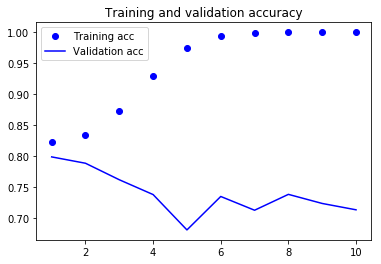

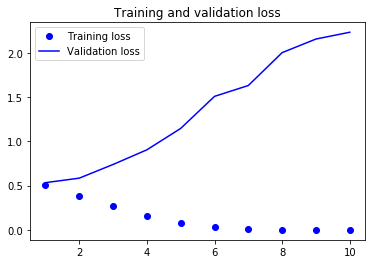

In [37]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()